In [2]:
import numpy as np
import pandas as pd
import datetime
import plotly.graph_objects as px
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [11]:
def convert_timestamp_to_datetime(timestamp_string):
    return datetime.datetime.strptime(timestamp_string, "%Y-%m-%d %H:%M:%S")

In [9]:
def map_between_min_and_max(value, min, max):
    try:
        return (value-min)/(max-min)
    except ZeroDivisionError:
        return 0

In [18]:
room_df = pd.read_csv('../../data/ROBOD/combined_Room4.csv')
room_df['timestamp'] = room_df['timestamp'].apply(convert_timestamp_to_datetime)

In [19]:
co2_min, co2_max = room_df['indoor_co2 [ppm]'].min(), room_df['indoor_co2 [ppm]'].max()
hum_min, hum_max = room_df['occupant_count [number]'].min(), room_df['occupant_count [number]'].max()
oco2_min, oco2_max = room_df['outdoor_co2 [ppm]'].min(), room_df['outdoor_co2 [ppm]'].max()
wifi_min, wifi_max = room_df['wifi_connected_devices [number]'].min(), room_df['wifi_connected_devices [number]'].max()
for column in [column for column in room_df.columns if column!='timestamp']:
    room_df[column] = room_df[column].apply(map_between_min_and_max, args=(room_df[column].min(), room_df[column].max()))

In [20]:
plot = px.Figure()

# Create and style traces
plot.add_trace(px.Scatter(x=room_df['timestamp'], y=room_df['indoor_co2 [ppm]'], name=f'CO2:[{co2_min:.1f}, {co2_max:.1f}]',
                         line=dict(color='black', width=2)))
plot.add_trace(px.Scatter(x=room_df['timestamp'], y=room_df['occupant_count [number]'], name = f'Occupancy:[{hum_min:.1f},{hum_max:.2f}]',
                         line=dict(color='royalblue', width=2)))
plot.add_trace(px.Scatter(x=room_df['timestamp'], y=room_df['outdoor_co2 [ppm]'], name = f'Outdoor CO2:[{oco2_min:.1f},{oco2_max:.2f}]',
                         line=dict(color='red', width=2)))
plot.add_trace(px.Scatter(x=room_df['timestamp'], y=room_df['supply_air_temperature [Celsius]'], name = f'Supply'))
plot.add_trace(px.Scatter(x=room_df['timestamp'], y=room_df['wifi_connected_devices [number]'], name = f'WiFi'))
plot.add_trace(px.Scatter(x=room_df['timestamp'], y=room_df['plug_load_energy [kWh]'], name = f'Plug'))

plot.update_layout(
    title="Change of measurements during 7-day period",
    xaxis_title="Date and time",
    yaxis_title="Normalized measurement value",
    legend_title="Measurement type",
    font=dict(
        family="Courier New, monospace",
        size=15,
        color="white"
    )
)

plot.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                    step="day",
                    stepmode="backward"),
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
    )
)

plot.show()

In [14]:
csv1 = pd.read_csv('../../data/ROBOD/combined_Room1.csv')
csv1['Room'] = 'Room 1'
csv2 = pd.read_csv('../../data/ROBOD/combined_Room2.csv')
csv2['Room'] = 'Room 2'
csv3 = pd.read_csv('../../data/ROBOD/combined_Room3.csv')
csv3['Room'] = 'Room 3'
csv4 = pd.read_csv('../../data/ROBOD/combined_Room4.csv')
csv4['Room'] = 'Room 4'
csv5 = pd.read_csv('../../data/ROBOD/combined_Room5.csv')
csv5['Room'] = 'Room 5'

In [15]:
total_csv = pd.concat([csv1, csv2, csv3, csv4, csv5], sort=False).sort_values(by=['timestamp', 'Room'])
total_csv.to_csv('../../data/ROBOD/combined.csv', index=False)

In [15]:
from sklearn.decomposition import PCA, NMF
import pandas as pd
from sklearn.impute import KNNImputer

In [ ]:
total_csv = pd.read_csv('../../data/ROBOD/combined.csv')

pct_null = total_csv.isnull().sum() / len(total_csv)
missing_features = pct_null[pct_null > 0.20].index
total_csv.drop(missing_features, axis=1, inplace=True)
filtered = total_csv.loc[:, ~total_csv.columns.isin(['timestamp', 'Room', 'occupant_presence [binary]','occupant_count [number]'])]
imputer = KNNImputer(n_neighbors=4, weights="uniform")
filtered = imputer.fit_transform(filtered)
filtered = PCA(n_components=2).fit_transform(filtered)
total_csv['PCA 1'] = filtered[:, 0]
total_csv['PCA 2'] = filtered[:, 1]

total_csv.to_csv('../../data/ROBOD/combined.csv', index=False)

In [20]:
total_csv = pd.read_csv('../../data/ROBOD/combined.csv')
filtered = total_csv.loc[:, ~total_csv.columns.isin(['PCA 1', 'PCA 2', 'timestamp', 'Room', 'occupant_presence [binary]','occupant_count [number]'])]
imputer = KNNImputer(n_neighbors=4, weights="uniform")
filtered = imputer.fit_transform(filtered)
nmf = NMF(n_components=2).fit_transform(filtered)
total_csv['NMF 1'] = nmf[:, 0]
total_csv['NMF 2'] = nmf[:, 1]
total_csv.to_csv('../../data/ROBOD/combined.csv', index=False)

# Preprocessing and cleaning

In [12]:
total_csv = pd.read_csv('../../data/ROBOD/combined.csv')
mask = (total_csv['Room']=='Room 3') | (total_csv['Room']=='Room 4') | (total_csv['Room']=='Room 5')
train_df = total_csv[mask]
test_df = total_csv[-mask]

In [13]:
# Reduces skew value from 20 to 1
total_csv['voc [ppb]'] = np.log(total_csv['voc [ppb]'])
# Standardize sound pressure because it looks like a shifted normal
sound_scaler = StandardScaler().fit(train_df['sound_pressure_level [dba]'].to_numpy().reshape(-1, 1))
total_csv.loc[mask, 'sound_pressure_level [dba]'] = sound_scaler.transform(total_csv.loc[mask, 'sound_pressure_level [dba]'].to_numpy().reshape(-1, 1))
total_csv.loc[-mask, 'sound_pressure_level [dba]'] = sound_scaler.transform(total_csv.loc[-mask, 'sound_pressure_level [dba]'].to_numpy().reshape(-1, 1))
# Use Min-Max scaler for relative humidity, since it is constrained by nature
rh_scaler = MinMaxScaler().fit(train_df['indoor_relative_humidity [%]'].to_numpy().reshape(-1, 1))
total_csv.loc[mask, 'indoor_relative_humidity [%]'] = rh_scaler.transform(total_csv.loc[mask, 'indoor_relative_humidity [%]'].to_numpy().reshape(-1, 1))
total_csv.loc[-mask, 'indoor_relative_humidity [%]'] = rh_scaler.transform(total_csv.loc[-mask, 'indoor_relative_humidity [%]'].to_numpy().reshape(-1, 1))
# Standardize temperature
temp_scaler = StandardScaler().fit(train_df['air_temperature [Celsius]'].to_numpy().reshape(-1,1))
total_csv.loc[mask, 'air_temperature [Celsius]'] = temp_scaler.transform(total_csv.loc[mask, 'air_temperature [Celsius]'].to_numpy().reshape(-1, 1))
total_csv.loc[-mask, 'air_temperature [Celsius]'] = temp_scaler.transform(total_csv.loc[-mask, 'air_temperature [Celsius]'].to_numpy().reshape(-1, 1))
# Remove outliers by maxing the lux levels to 3000 (For bright indoor readings), then log-transforming (we can use the whole dataset)
total_csv.loc[total_csv['illuminance [lux]']>2500, 'illuminance [lux]'] = 2500
total_csv['illuminance [lux]'] = np.log(total_csv['illuminance [lux]']+0.1)
# Log-transform the pm2.5 measurements
total_csv['pm2.5 [mu_g/m3]'] = np.log(total_csv['pm2.5 [mu_g/m3]']+0.1)
# Log-transform the Co2 measurements
total_csv['indoor_co2 [ppm]'] = np.log(total_csv['indoor_co2 [ppm]']-395)
# Sqrt-transform the Wi-fi
total_csv['wifi_connected_devices [number]'] = np.sqrt(total_csv['wifi_connected_devices [number]'])
# Sqrt-transform the Ceiling fan energy
total_csv['ceiling_fan_energy [kWh]'] = np.sqrt(total_csv['ceiling_fan_energy [kWh]'])
# Sqrt-transform the Lighting fan energy
total_csv['lighting_energy [kWh]'] = np.sqrt(total_csv['lighting_energy [kWh]'])
# Sqrt-transform the Plug Load energy
total_csv['plug_load_energy [kWh]'] = np.sqrt(total_csv['plug_load_energy [kWh]'])
# Sqrt-transform the chilled water energy
total_csv['chilled_water_energy [kWh]'] = np.sqrt(total_csv['chilled_water_energy [kWh]'])
# Center the supply air temperature using train set mean
total_csv['supply_air_temperature [Celsius]'] = total_csv['supply_air_temperature [Celsius]'] - total_csv.loc[mask, 'supply_air_temperature [Celsius]'].mean()
# Digitize the supply air pressure levels
total_csv['supply_air_pressure [Pa]'] = np.digitize(total_csv['supply_air_pressure [Pa]'], bins=np.array([0.0, 1, 80.0, 160.0, 300.0]))-1
# Standardize the baromatic pressure
baro_pressure_scaler = StandardScaler().fit(train_df['baromatic_pressure [hPa]'].to_numpy().reshape(-1, 1))
total_csv.loc[mask, 'baromatic_pressure [hPa]'] = baro_pressure_scaler.transform(train_df['baromatic_pressure [hPa]'].to_numpy().reshape(-1, 1))
total_csv.loc[-mask, 'baromatic_pressure [hPa]'] = baro_pressure_scaler.transform(total_csv.loc[-mask, 'baromatic_pressure [hPa]'].to_numpy().reshape(-1, 1))
# Standardize the dry bulb temperature
dry_bulb_scaler = StandardScaler().fit(train_df['dry_bulb_temp [Celsius]'].to_numpy().reshape(-1, 1))
total_csv.loc[mask, 'dry_bulb_temp [Celsius]'] = dry_bulb_scaler.transform(train_df['dry_bulb_temp [Celsius]'].to_numpy().reshape(-1, 1))
total_csv.loc[-mask, 'dry_bulb_temp [Celsius]'] = dry_bulb_scaler.transform(total_csv.loc[-mask, 'dry_bulb_temp [Celsius]'].to_numpy().reshape(-1, 1))
# Sqrt transform global horizontal solar radiation
total_csv['global_horizontal_solar_radiation [W/m2]'] = np.sqrt(total_csv['global_horizontal_solar_radiation [W/m2]'])
# Add sin and cos of wind direction
total_csv['wind_direction [Degree] - sin'] = np.sin(total_csv['wind_direction [Degree]'] * np.pi / 180.0)
total_csv['wind_direction [Degree] - cos'] = np.cos(total_csv['wind_direction [Degree]'] * np.pi / 180.0)
total_csv = total_csv.drop('wind_direction [Degree]', axis=1)
# Sqrt transform the wind speed
total_csv['wind_speed [m/s]'] = np.sqrt(total_csv['wind_speed [m/s]'])
# # Log-transform the outdoor Co2 measurements
total_csv.loc[mask, 'outdoor_co2 [ppm]'] = np.log(total_csv.loc[mask, 'outdoor_co2 [ppm]']-399)
total_csv.loc[-mask, 'outdoor_co2 [ppm]'] = np.log(total_csv.loc[-mask, 'outdoor_co2 [ppm]']-399)
# Use Min-Max scaler for outdoor relative humidity, since it is constrained by nature
outdoor_rh_scaler = MinMaxScaler().fit(train_df['outdoor_relative_humidity [%]'].to_numpy().reshape(-1, 1))
total_csv.loc[mask, 'outdoor_relative_humidity [%]'] = outdoor_rh_scaler.transform(total_csv.loc[mask, 'outdoor_relative_humidity [%]'].to_numpy().reshape(-1, 1))
total_csv.loc[-mask, 'outdoor_relative_humidity [%]'] = outdoor_rh_scaler.transform(total_csv.loc[-mask, 'outdoor_relative_humidity [%]'].to_numpy().reshape(-1, 1))

In [14]:
total_csv['timestamp'] = total_csv['timestamp'].apply(convert_timestamp_to_datetime)

In [15]:
def convert_seconds_to_sin(seconds):
    return np.sin(seconds*2*np.pi/86400)

def convert_timestamp_to_sin(timestamp):
    seconds = timestamp.hour*3600+timestamp.minute*60+timestamp.second
    return convert_seconds_to_sin(seconds)

def convert_seconds_to_cos(seconds):
    return np.cos(seconds*2*np.pi/86400)

def convert_timestamp_to_cos(timestamp):
    seconds = timestamp.hour*3600+timestamp.minute*60+timestamp.second
    return convert_seconds_to_cos(seconds)

total_csv['timestamp_sin'] = total_csv['timestamp'].apply(convert_timestamp_to_sin)
total_csv['timestamp_cos'] = total_csv['timestamp'].apply(convert_timestamp_to_cos)

In [17]:
total_csv.to_csv('../../data/ROBOD/combined_cleaned.csv', index=False)

### Adding 15 min and 30 min occupancy information

In [18]:
total_csv = pd.read_csv('../../data/ROBOD/combined_cleaned.csv')
total_csv['timestamp'] = total_csv['timestamp'].apply(convert_timestamp_to_datetime)
total_csv['Occupancy15Min'] = 0
total_csv['Occupancy30Min'] = 0

for room in ['Room 1', 'Room 2', 'Room 3', 'Room 4', 'Room 5']:
    room_df = total_csv.loc[total_csv['Room'] == room, :]
    lagged_15 = room_df['occupant_presence [binary]'].shift(-3)
    difference_15 = -room_df['timestamp'].diff(periods=-3)
    indices_15 = difference_15 != datetime.timedelta(minutes=15)
    lagged_15[indices_15] = -1
    total_csv.loc[total_csv['Room'] == room, 'Occupancy15Min'] = lagged_15

    lagged_30 = room_df['occupant_presence [binary]'].shift(-6)
    difference_30 = -room_df['timestamp'].diff(periods=-6)
    indices_30 = difference_30 != datetime.timedelta(minutes=30)
    lagged_30[indices_30] = -1
    total_csv.loc[total_csv['Room'] == room, 'Occupancy30Min'] = lagged_30

total_csv.to_csv('../../data/ROBOD/combined_cleaned.csv')

# Feature scoring

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

total_cleaned = pd.read_csv('../../data/ROBOD/combined_cleaned.csv')
mask = (total_cleaned['Room']=='Room 3') | (total_cleaned['Room']=='Room 4') | (total_cleaned['Room']=='Room 5')
total_cleaned2 = total_cleaned.drop(['timestamp', 'occupant_count [number]', 'PCA 1', 'PCA 2', 'NMF 1', 'NMF 2', 'Room', 'supply_air_pressure [Pa]', 'supply_air_temperature [Celsius]'], axis=1)
train_df = total_cleaned2[mask]

In [19]:
from sklearn.impute import KNNImputer

print("NA rows before: ", total_cleaned2.isna().sum().sum())
imputer = KNNImputer(n_neighbors=4, weights="uniform")
filtered = imputer.fit_transform(total_cleaned2)
total_cleaned[total_cleaned2.columns] = filtered
print("NA rows after: ", total_cleaned.isna().sum().sum())
total_cleaned = total_cleaned.drop(['occupant_count [number]', 'PCA 1', 'PCA 2', 'NMF 1', 'NMF 2', 'supply_air_pressure [Pa]', 'supply_air_temperature [Celsius]', 'temp_setpoint [Celsius]'], axis=1)
total_cleaned.to_csv('../../data/ROBOD/combined_cleaned.csv', index=False)

NA rows before:  520
NA rows after:  0


In [6]:
total_cleaned = pd.read_csv('../../data/ROBOD/combined_cleaned.csv')
def convert_timestamp_to_datetime(timestamp_string):
    return datetime.datetime.strptime(timestamp_string, "%Y-%m-%d %H:%M:%S")

total_cleaned['timestamp'] = total_cleaned['timestamp'].apply(convert_timestamp_to_datetime)
total_cleaned['Weekday'] = total_cleaned['timestamp'].apply(lambda x: x.weekday())

one_hot = pd.get_dummies(total_cleaned['Weekday'])
total_cleaned.drop('Weekday', axis=1, inplace=True)
total_cleaned = pd.concat([total_cleaned, one_hot], axis=1)

In [7]:
total_cleaned.to_csv('../../data/ROBOD/combined_cleaned.csv', index=False)

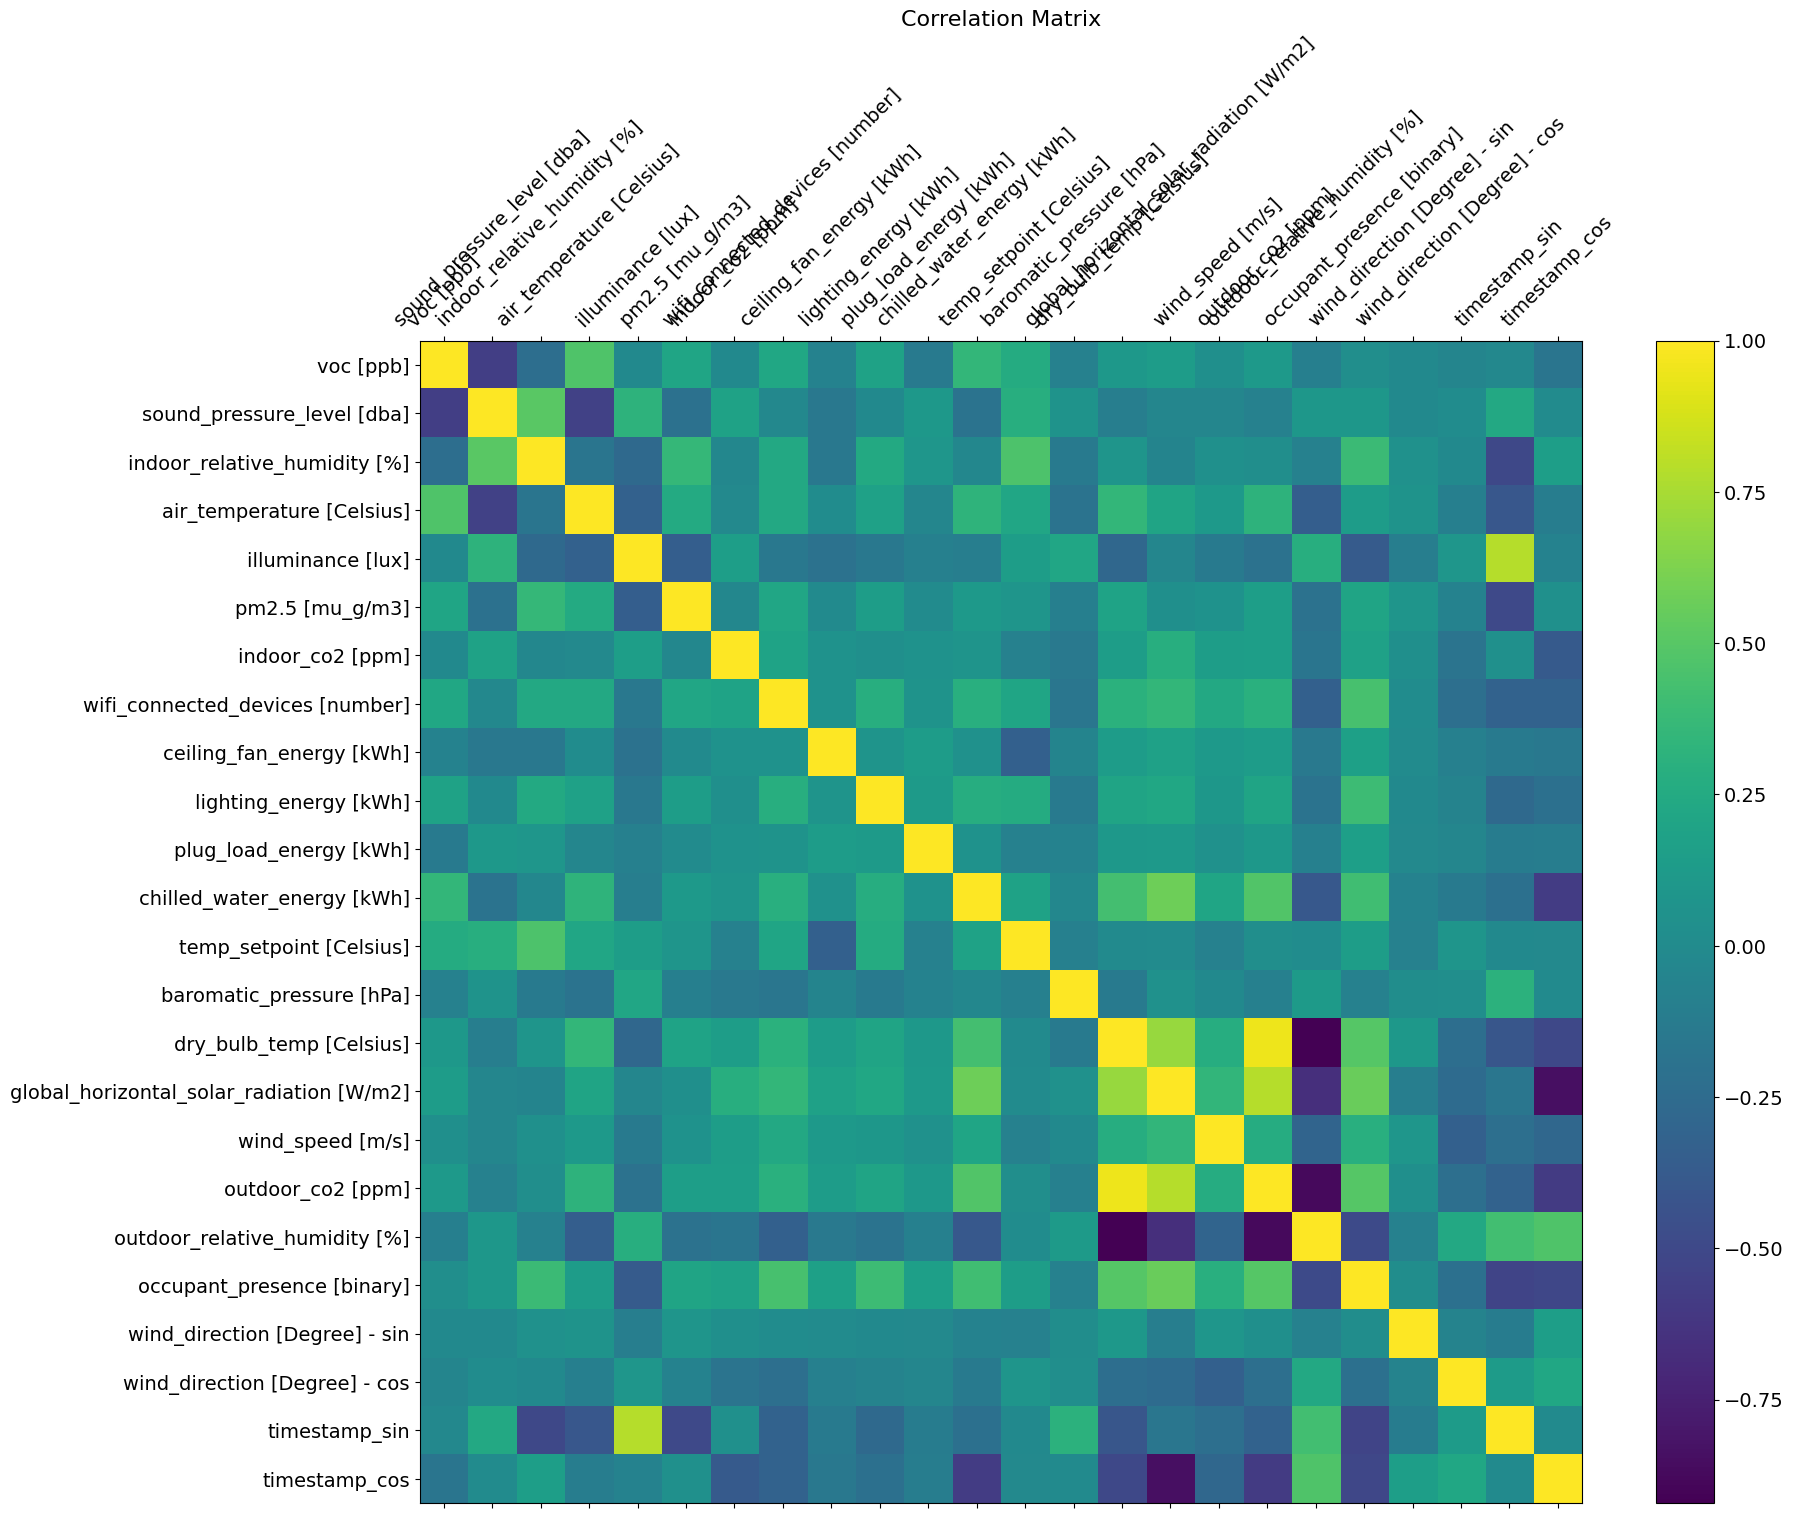

In [18]:
f = plt.figure(figsize=(19, 15))
plt.matshow(train_df.corr(), fignum=f.number)
plt.xticks(range(total_cleaned.select_dtypes(['number']).shape[1]), total_cleaned.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(total_cleaned.select_dtypes(['number']).shape[1]), total_cleaned.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

Feature: voc ppb, Score: 0.00966
Feature: sound_pressure_level dba, Score: 0.04599
Feature: indoor_relative_humidity %, Score: 0.09699
Feature: air_temperature Celsius, Score: 0.01417
Feature: illuminance lux, Score: 0.01584
Feature: pm2.5 mu_g/m3, Score: 0.01450
Feature: indoor_co2 ppm, Score: 0.02059
Feature: wifi_connected_devices number, Score: 0.03685
Feature: ceiling_fan_energy kWh, Score: 0.02881
Feature: lighting_energy kWh, Score: 0.08443
Feature: plug_load_energy kWh, Score: 0.01967
Feature: chilled_water_energy kWh, Score: 0.01261
Feature: temp_setpoint Celsius, Score: 0.02348
Feature: baromatic_pressure hPa, Score: 0.00953
Feature: dry_bulb_temp Celsius, Score: 0.01045
Feature: global_horizontal_solar_radiation W/m2, Score: 0.35470
Feature: wind_speed m/s, Score: 0.00538
Feature: outdoor_co2 ppm, Score: 0.01123
Feature: outdoor_relative_humidity %, Score: 0.01305
Feature: wind_direction Degree - sin, Score: 0.00499
Feature: wind_direction Degree - cos, Score: 0.00367
Featur

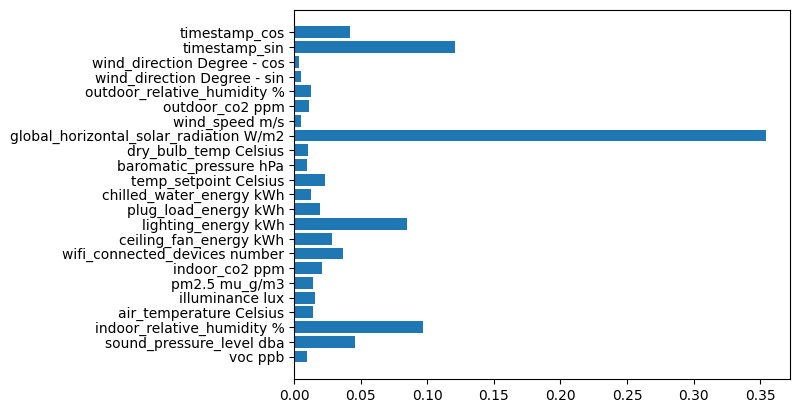

In [26]:
from sklearn.datasets import make_classification
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
# define dataset
y = train_df['occupant_presence [binary]']
X = train_df.loc[:, train_df.columns != 'occupant_presence [binary]']
X.columns = [s.translate({ord(i): None for i in '[]<'}) for s in X.columns]
# define the model
model = XGBClassifier()
# fit the model
model.fit(X, y)
# get importance
importance = model.feature_importances_
# summarize feature importance
for (i,v), names in zip(enumerate(importance), X.columns):
 print(f'Feature: {names}, Score: {v:.5f}')
# plot feature importance
plt.barh([x for x in range(len(importance))], importance)
plt.yticks(ticks=range(0,23), labels=X.columns)
plt.show()